### MCMC Neural Network
Random-walk MCMC for Bayesian neural network for time series prediction problem. Note that no Langevin-gradients are used in this version.

0 6.379422697814334 -40.5214858059831 0.20993330111308642 0.23867895353380247 [ 1.94139818 -0.09567214 -1.09815457  1.15338803 -0.7674051  -0.22647414
 -0.57384984 -2.45172779  1.62036334 -1.31133566 -0.09537845  0.29235966
 -0.20738936 -0.28173255 -1.28891787 -0.97556536  1.41424506  0.26113201
 -0.87134219 -1.03177385 -2.06749722  0.82880216 -2.55734968  1.74381463
  0.11691344 -0.10969986 -0.93496124 -0.14350222 -0.61140162  0.60280848
  0.04010445]  accepted
50 162.70160390132168 -40.50678709881704 0.13941619112806333 0.11453839726694033 [ 1.93293661 -0.13333009 -0.91999053  1.11544262 -0.97495905 -0.27136024
 -0.61297743 -2.42353102  1.71531886 -1.36836582 -0.16947004  0.22307636
  0.05408795 -0.1886313  -1.32243696 -1.0634586   1.39739871  0.22960833
 -0.89857559 -0.92000983 -2.07695789  0.52537255 -2.83833263  1.68830942
  0.0036278  -0.18972901 -0.90555516 -0.47617995 -0.62790678  0.74161042
  0.01961933]  accepted
150 239.3621532125268 -40.601573968261626 0.09049100693833108 0

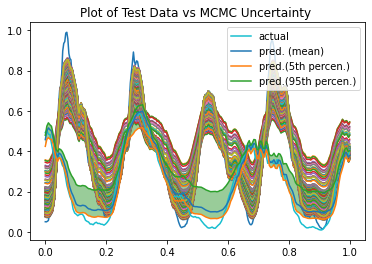

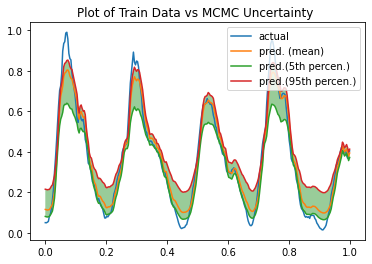

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

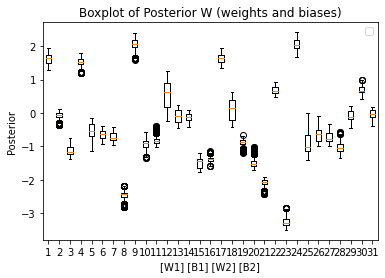

<Figure size 432x288 with 0 Axes>

In [2]:
# !/usr/bin/python

# MCMC Random Walk for Feedforward Neural Network for One-Step-Ahead Chaotic Time Series Prediction
# Data (Sunspot and Lazer). Taken' Theorem used for Data Reconstruction (Dimension = 4, Timelag = 2).
# Data procesing file is included.

# RMSE (Root Mean Squared Error)

# based on: https://github.com/rohitash-chandra/FNN_TimeSeries
# based on: https://github.com/rohitash-chandra/mcmc-randomwalk

# Rohitash Chandra, Centre for Translational Data Science
# University of Sydey, Sydney NSW, Australia.  2017 c.rohitash@gmail.conm
# https://www.researchgate.net/profile/Rohitash_Chandra

# Reference for publication for this code
# [Chandra_ICONIP2017] R. Chandra, L. Azizi, S. Cripps, 
# 'Bayesian neural learning via Langevin dynamicsfor chaotic time series prediction', ICONIP 2017.
# (to be addeded on https://www.researchgate.net/profile/Rohitash_Chandra)

import matplotlib.pyplot as plt
import numpy as np
import random
import time
import math


# An example of a class
class Network:
    def __init__(self, Topo, Train, Test):
        self.Top = Topo     # NN topology [input, hidden, output]
        self.TrainData = Train
        self.TestData = Test
        np.random.seed()

        self.W1 = np.random.randn(self.Top[0], self.Top[1]) / np.sqrt(self.Top[0])
        self.B1 = np.random.randn(1, self.Top[1]) / np.sqrt(self.Top[1])    # bias first layer
        self.W2 = np.random.randn(self.Top[1], self.Top[2]) / np.sqrt(self.Top[1])
        self.B2 = np.random.randn(1, self.Top[2]) / np.sqrt(self.Top[1])    # bias second layer

        self.hidout = np.zeros((1, self.Top[1]))  # output of first hidden layer
        self.out = np.zeros((1, self.Top[2]))     # output last layer

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sampleEr(self, actualout):
        error = np.subtract(self.out, actualout)
        sqerror = np.sum(np.square(error)) / self.Top[2]
        return sqerror

    def ForwardPass(self, X):
        z1 = X.dot(self.W1) - self.B1
        self.hidout = self.sigmoid(z1)  # output of first hidden layer
        z2 = self.hidout.dot(self.W2) - self.B2
        self.out = self.sigmoid(z2)     # output second hidden layer

    def BackwardPass(self, Input, desired, vanilla):
        out_delta = (desired - self.out) * (self.out * (1 - self.out))
        hid_delta = out_delta.dot(self.W2.T) * (self.hidout * (1 - self.hidout))

        self.W2 += (self.hidout.T.dot(out_delta) * self.lrate)
        self.B2 += (-1 * self.lrate * out_delta)
        self.W1 += (Input.T.dot(hid_delta) * self.lrate)
        self.B1 += (-1 * self.lrate * hid_delta)

    def decode(self, w):
        w_layer1size = self.Top[0] * self.Top[1]
        w_layer2size = self.Top[1] * self.Top[2]

        w_layer1 = w[0:w_layer1size]
        self.W1 = np.reshape(w_layer1, (self.Top[0], self.Top[1]))

        w_layer2 = w[w_layer1size:w_layer1size + w_layer2size]
        self.W2 = np.reshape(w_layer2, (self.Top[1], self.Top[2]))
        self.B1 = w[w_layer1size + w_layer2size:w_layer1size + w_layer2size + self.Top[1]]
        self.B2 = w[w_layer1size + w_layer2size + self.Top[1]:w_layer1size + w_layer2size + self.Top[1] + self.Top[2]]

    def evaluate_proposal(self, data, w):   # BP with SGD (Stocastic BP)

        self.decode(w)  # method to decode w into W1, W2, B1, B2.

        size = data.shape[0]

        Input = np.zeros((1, self.Top[0]))   # temp hold input
        Desired = np.zeros((1, self.Top[2]))
        fx = np.zeros(size)

        for pat in range(0, size):
            Input[:] = data[pat, 0:self.Top[0]]
            Desired[:] = data[pat, self.Top[0]:]

            self.ForwardPass(Input)
            fx[pat] = self.out

        return fx

# --------------------------------------------------------------------------

class MCMC:
    
    def __init__(self, samples, traindata, testdata, topology):
        self.samples = samples     # NN topology [input, hidden, output]
        self.topology = topology   # max epocs
        self.traindata = traindata
        self.testdata = testdata
        
        
    def rmse(self, predictions, targets):
        return np.sqrt(((predictions - targets) ** 2).mean())
    
        
    def likelihood_func(self, neuralnet, data, w, tausq):
        y = data[:, self.topology[0]]
        fx = neuralnet.evaluate_proposal(data, w)
        rmse = self.rmse(fx, y)
        n = y.shape[0]
        loss =( -(n/2) * np.log(2 * math.pi * tausq)) - ( (1/(2*tausq)) * np.sum(np.square(y - fx)))
        
        return [loss, fx, rmse]
    

    def prior_likelihood(self, sigma_squared, nu_1, nu_2, w, tausq):
        h = self.topology[1]  # number hidden neurons
        d = self.topology[0]  # number input neurons
        part1 = -1 * ((d * h + h + 2) / 2) * np.log(sigma_squared)
        part2 = 1 / (2 * sigma_squared) * (sum(np.square(w)))
        log_loss = part1 - part2 - (1 + nu_1) * np.log(tausq) - (nu_2 / tausq)
        return log_loss
    

    def sampler(self):
        # Initialize MCMC
        testsize = self.testdata.shape[0]
        trainsize = self.traindata.shape[0]
        samples = self.samples

        x_test = np.linspace(0, 1, num=testsize)
        x_train = np.linspace(0, 1, num=trainsize)

        netw = self.topology     # [input, hidden, output]
        y_test = self.testdata[:, netw[0]]
        y_train = self.traindata[:, netw[0]]
       
        w_size = (netw[0] * netw[1]) + (netw[1] * netw[2]) + netw[1] + netw[2]  # num of weights and bias

        pos_w = np.ones((samples, w_size))     # posterior of all weights and bias over all samples
        pos_tau = np.ones((samples, 1))

        fxtrain_samples = np.ones((samples, trainsize))  # fx of train data over all samples
        fxtest_samples = np.ones((samples, testsize))    # fx of test data over all samples
        rmse_train = np.zeros(samples)
        rmse_test = np.zeros(samples)

        w = np.random.randn(w_size)
        w_proposal = np.random.randn(w_size)

        step_w = 0.02     # defines how much variation you need in changes to w
        step_eta = 0.01
        
        # Declare FNN and initialize
        neuralnet = Network(self.topology, self.traindata, self.testdata)
        
        pred_train = neuralnet.evaluate_proposal(self.traindata, w)
        pred_test = neuralnet.evaluate_proposal(self.testdata, w)

        eta = np.log(np.var(pred_train - y_train))
        tau_pro = np.exp(eta)

        sigma_squared = 25
        nu_1 = 0
        nu_2 = 0

        prior_likelihood = self.prior_likelihood(sigma_squared, nu_1, nu_2, w, tau_pro)  # takes care of the gradients

        [likelihood, pred_train, rmsetrain] = self.likelihood_func(neuralnet, self.traindata, w, tau_pro)
        [likelihood_ignore, pred_test, rmsetest] = self.likelihood_func(neuralnet, self.testdata, w, tau_pro)
 
        naccept = 0

        plt.plot(x_train, y_train)

        for i in range(samples - 1):

            w_proposal = w + np.random.normal(0, step_w, w_size)

            eta_pro = eta + np.random.normal(0, step_eta, 1)
            tau_pro = math.exp(eta_pro)

            [likelihood_proposal, pred_train, rmsetrain] = self.likelihood_func(neuralnet, self.traindata, 
                                                                                w_proposal, tau_pro)
            
            [likelihood_ignore, pred_test, rmsetest] = self.likelihood_func(neuralnet, self.testdata, 
                                                                            w_proposal, tau_pro)

            # likelihood_ignore  refers to parameter that will not be used in the alg.

            prior_prop = self.prior_likelihood(sigma_squared, nu_1, nu_2, w_proposal, tau_pro)
            # takes care of the gradients

            diff_likelihood = likelihood_proposal - likelihood
            diff_priorliklihood = prior_prop - prior_likelihood

            mh_prob = min(1, math.exp(diff_likelihood + diff_priorliklihood))

            u = random.uniform(0, 1)

            if u < mh_prob:
                # Update position 
                naccept += 1
                likelihood = likelihood_proposal
                prior_likelihood = prior_prop
                w = w_proposal
                eta = eta_pro
                if i%50 == 0:
                    print(i, likelihood, prior_likelihood, rmsetrain, rmsetest, w, ' accepted')

                pos_w[i + 1,] = w_proposal
                pos_tau[i + 1,] = tau_pro
                fxtrain_samples[i + 1,] = pred_train
                fxtest_samples[i + 1,] = pred_test
                rmse_train[i + 1,] = rmsetrain
                rmse_test[i + 1,] = rmsetest

                plt.plot(x_train, pred_train)

            else:
                pos_w[i + 1,] = pos_w[i,]
                pos_tau[i + 1,] = pos_tau[i,]
                fxtrain_samples[i + 1,] = fxtrain_samples[i,]
                fxtest_samples[i + 1,] = fxtest_samples[i,]
                rmse_train[i + 1,] = rmse_train[i,]
                rmse_test[i + 1,] = rmse_test[i,] 

        print(naccept, ' num accepted')
        print(naccept / (samples * 1.0), '% was accepted')
        accept_ratio = naccept / (samples * 1.0) * 100
 
        return (pos_w, pos_tau, fxtrain_samples, fxtest_samples, x_train, x_test, rmse_train, rmse_test, accept_ratio)


def main():
    outres = open('datasets/results4.txt', 'w')
    
    for problem in range(2, 3): 

        hidden = 5
        input = 4
        output = 1

        if problem == 1:
            traindata = np.loadtxt("datasets/lazer/train.txt")
            testdata = np.loadtxt("datasets/lazer/test.txt")
        if problem == 2:
            traindata = np.loadtxt("datasets/sunspot/train.txt")
            testdata = np.loadtxt("datasets/sunspot/test.txt")
        if problem == 3:
            traindata = np.loadtxt("datasets/mackey/train.txt")
            testdata = np.loadtxt("datasets/mackey/test.txt")

        topology = [input, hidden, output]

        MinCriteria = 0.005   # stop when RMSE reaches MinCriteria (problem dependent)

        random.seed(time.time())

        numSamples = 1000  # need to decide yourself

        mcmc = MCMC(numSamples, traindata, testdata, topology)  # declare class

        [pos_w, pos_tau, fx_train, fx_test, x_train, x_test, rmse_train, rmse_test, accept_ratio] = mcmc.sampler()
        
        burnin = 0.1 * numSamples  # use post burn in samples

        pos_w = pos_w[int(burnin):, ]
        pos_tau = pos_tau[int(burnin):, ]

        fx_mu = fx_test.mean(axis=0)
        fx_high = np.percentile(fx_test, 95, axis=0)
        fx_low = np.percentile(fx_test, 5, axis=0)

        fx_mu_tr = fx_train.mean(axis=0)
        fx_high_tr = np.percentile(fx_train, 95, axis=0)
        fx_low_tr = np.percentile(fx_train, 5, axis=0)

        rmse_tr = np.mean(rmse_train[int(burnin):])
        rmsetr_std = np.std(rmse_train[int(burnin):])
        rmse_tes = np.mean(rmse_test[int(burnin):])
        rmsetest_std = np.std(rmse_test[int(burnin):]) 
        np.savetxt(outres, (rmse_tr, rmsetr_std, rmse_tes, rmsetest_std, accept_ratio), fmt='%1.5f')

        ytestdata = testdata[:, input]
        ytraindata = traindata[:, input]
        
        # -----------------------------------------
        plt.plot(x_test, ytestdata, label='actual')
        plt.plot(x_test, fx_mu, label='pred. (mean)')
        plt.plot(x_test, fx_low, label='pred.(5th percen.)')
        plt.plot(x_test, fx_high, label='pred.(95th percen.)')
        plt.fill_between(x_test, fx_low, fx_high, facecolor='g', alpha=0.4)
        plt.legend(loc='upper right')
        plt.title("Plot of Test Data vs MCMC Uncertainty ")
        #plt.savefig('figures/mcmcrestest.png') 
        plt.show()
        plt.clf()
        
        # -----------------------------------------
        plt.plot(x_train, ytraindata, label='actual')
        plt.plot(x_train, fx_mu_tr, label='pred. (mean)')
        plt.plot(x_train, fx_low_tr, label='pred.(5th percen.)')
        plt.plot(x_train, fx_high_tr, label='pred.(95th percen.)')
        plt.fill_between(x_train, fx_low_tr, fx_high_tr, facecolor='g', alpha=0.4)
        plt.legend(loc='upper right')
        plt.title("Plot of Train Data vs MCMC Uncertainty ")
        #plt.savefig('figures/mcmcrestrain.png')
        plt.show()
        plt.clf()
        
        # -----------------------------------------
        mpl_fig = plt.figure()
        ax = mpl_fig.add_subplot(111)
        ax.boxplot(pos_w)
        ax.set_xlabel('[W1] [B1] [W2] [B2]')
        ax.set_ylabel('Posterior')
        plt.legend(loc='upper right')
        plt.title("Boxplot of Posterior W (weights and biases)")
        #plt.savefig('figures/w_pos.png') 
        plt.show()
        plt.clf()


if __name__ == "__main__": 
    main()